In [53]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
from sklearn.metrics import confusion_matrix

import os
import pandas as pd
import time
import warnings
from tqdm import tqdm

import librosa
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(f"Using device: {device}")

warnings.filterwarnings('ignore')

Using device: cuda


In [42]:
class SpectrogramDataset(Dataset):
    def __init__(self, csv_file, spectrogram_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(csv_file)
        self.spectrograms = spectrogram_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_map = {
            'Drone': 0,
            'No Drone': 1
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spectrogram_filename = f"{self.df.iloc[idx, 0][0:-4]}_spectrogram.pt"
        spectrogram_path = os.path.join(self.spectrograms, spectrogram_filename)
        spectrogram = torch.load(spectrogram_path)
        spectrogram = torch.nan_to_num(spectrogram)
        label = self.df.iloc[idx, 1]
        
        return spectrogram, torch.tensor(label)
    

# Usage example
csv_file = "./Anechoic_ESC50_mfccsdeltas.csv"
spectrogram_dir = "./Anechoic_ESC50_spectrograms"

# Define any transformations if needed
transform = None
target_transform = None

dataset = SpectrogramDataset(csv_file, spectrogram_dir, transform=transform, target_transform=target_transform)

In [43]:
train_size = int(.8 * len(dataset))
test_size = int(.75 * (len(dataset) - train_size))
val_size = len(dataset) - train_size - test_size

train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])
print(train_dataset)
print(train_dataset[0])

# Using torch.utils.data.weightedRandomSampler to deal with non-uniform dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
    # sampler=WeightedRandomSampler(weights=label_weights, num_samples=train_size, replacement=True)
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False
)

(tensor([[[ 0.4732,  0.6592,  0.4277,  ...,  0.8089,  0.1773,  0.8933],
         [ 0.5984,  0.7891,  0.8158,  ...,  0.8849,  0.9407,  0.9107],
         [ 0.6407,  0.8242,  0.8879,  ...,  0.8468,  0.9016,  0.8857],
         ...,
         [-0.7594, -0.8687, -1.0000,  ..., -1.0000, -0.7027, -0.5108],
         [-0.7616, -0.9292, -1.0000,  ..., -1.0000, -0.6859, -0.5084],
         [-0.7699, -0.9190, -1.0000,  ..., -1.0000, -0.7411, -0.5137]]]), tensor(0))


In [27]:
for spectrogram, label in test_loader:
    if(spectrogram.mean() == -1):
        print(spectrogram)

In [4]:
print(train_dataset[7][0].shape)


torch.Size([1, 1025, 87])


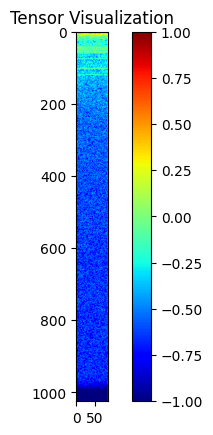

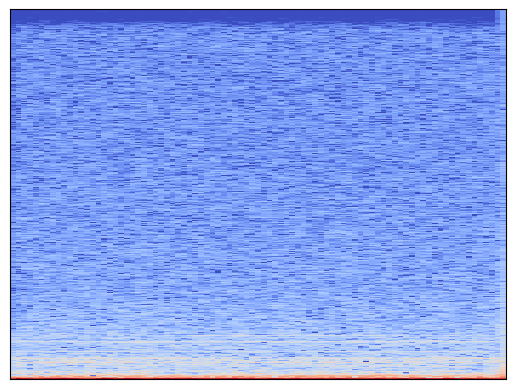

In [44]:
tensor_size = (1,201,442)
i = 3
tensor = train_dataset[i][0][0]
plt.imshow(tensor, cmap='jet')
plt.title('Tensor Visualization')
plt.colorbar()
plt.show()

librosa.display.specshow(train_dataset[i][0][0].numpy())
plt.show()



In [45]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.LazyConv2d(4, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConv2d(8, 5, stride=2),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.MaxPool2d(5, stride=2),

            # Linear perceptron for classification
            nn.Flatten(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1024),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(256),
            nn.LazyBatchNorm1d(),
            nn.ReLU(),
            nn.LazyLinear(1)
    )

    def forward(self, x):
        logits = self.seq(x).squeeze(dim=1)
        return logits


In [46]:
def split_seconds(seconds):
    minutes = seconds // 60
    hours = minutes // 60
    days = hours // 24
    return seconds % 60, minutes % 60, hours % 24, days


In [47]:
def main():
    # Define model
    model = CNN()

    # Cuda setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    model = model.to(device)
   
    print(f"Using device: {device}")
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-4)
   
    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")
   
    # Number of epochs
    num_epochs = 64
   
    # Train or load model?
    print("Training model....")
    start = time.time()
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        
        model.train()
        for batch_idx, (features, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
           
            # CNN forward pass
            logits = model(features)
            # print(torch.round(torch.sigmoid(logits)))
            loss = loss_fn(logits, labels.to(float))
            loss.backward()
            optimizer.step()

        model.eval()
        num_test = 0
        num_correct = 0
        total_loss = 0
        with torch.no_grad():
            for features, labels in tqdm(test_loader, desc="Testing"):
                features, labels = features.to(device), labels.to(device)
                logits = model(features)
                loss = loss_fn(logits, labels.to(float))
                total_loss += loss.item()
                preds = torch.round(torch.sigmoid(logits))
                num_test += labels.size(0)
                num_correct += preds.eq(labels).sum().item()
    
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")

        # torch.save(model.state_dict(), f"./dnd_spectrogram_models/_epoch_{str(epoch)}.pt")
   
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Training Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")
   
    # Evaluate model on validation data
    model.eval()
    print("Evaluating model....")
    start = time.time()
    total_loss = 0
    num_test = 0
    num_correct = 0
   
    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validating"):
            features, labels = features.to(device), labels.to(device)
            logits = model(features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()
   
    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")
    end = time.time()
    seconds, minutes, hours, days = split_seconds(end - start)
    print(f"Testing Runtime: {int(days)}d {int(hours)}h {int(minutes)}m {seconds:.2f}s")

In [60]:
main()

Using device: cuda
Training model....


Epochs:   0%|          | 0/64 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [62]:
# Define model
model = CNN()
# Cuda setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model = model.to(device)

print(f"Using device: {device}")

directory = "./dnd_spectrogram_models"

for file in os.listdir(directory):
    # Optimizer setup
    optimizer = Adam(model.parameters(), lr=1e-3)

    # Loss function
    loss_fn = nn.BCEWithLogitsLoss(reduction="mean")

    # Load model
    filepath = os.path.join(directory, file)
    state = torch.load(filepath)
    model.load_state_dict(state)

    # Evaluate model on validation data
    model.eval()
    print(f"Evaluating model {file}")
    total_loss = 0
    num_test = 0
    num_correct = 0

    with torch.no_grad():
        for features, labels in tqdm(val_loader, desc="Validating"):
            features, labels = features.to(device), labels.to(device)
            logits = model(features)
            loss = loss_fn(logits, labels.to(float))
            total_loss += loss.item()
            preds = torch.round(torch.sigmoid(logits))
            num_test += labels.size(0)
            num_correct += preds.eq(labels).sum().item()

    print(f"Test accuracy: {num_correct / num_test * 100:.2f}, Total loss: {total_loss}")


Using device: cuda
Evaluating model _epoch_0.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 10.44it/s]


Test accuracy: 99.07, Total loss: 0.5319350985155324
Evaluating model _epoch_1.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.72it/s]


Test accuracy: 100.00, Total loss: 0.2934851992025263
Evaluating model _epoch_10.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.65it/s]


Test accuracy: 99.90, Total loss: 0.05514648776455999
Evaluating model _epoch_11.pt


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.18it/s]


Test accuracy: 100.00, Total loss: 0.01537497689330003
Evaluating model _epoch_12.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.27it/s]


Test accuracy: 100.00, Total loss: 0.008964214379243588
Evaluating model _epoch_13.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 10.46it/s]


Test accuracy: 100.00, Total loss: 0.007502628117048123
Evaluating model _epoch_14.pt


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.07it/s]


Test accuracy: 100.00, Total loss: 0.008589125655841615
Evaluating model _epoch_15.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.12it/s]


Test accuracy: 100.00, Total loss: 0.012854437374255845
Evaluating model _epoch_16.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 10.34it/s]


Test accuracy: 99.90, Total loss: 0.06332572199650421
Evaluating model _epoch_2.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 10.55it/s]


Test accuracy: 100.00, Total loss: 0.0781936387083988
Evaluating model _epoch_3.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.36it/s]


Test accuracy: 99.90, Total loss: 0.06930513341274036
Evaluating model _epoch_4.pt


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.03it/s]


Test accuracy: 99.69, Total loss: 0.10052867583283387
Evaluating model _epoch_5.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 11.37it/s]


Test accuracy: 99.90, Total loss: 0.06456266892353806
Evaluating model _epoch_6.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 10.27it/s]


Test accuracy: 99.79, Total loss: 0.12164637937979943
Evaluating model _epoch_7.pt


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.90it/s]


Test accuracy: 100.00, Total loss: 0.012124657314776263
Evaluating model _epoch_8.pt


Validating: 100%|██████████| 16/16 [00:01<00:00, 12.21it/s]


Test accuracy: 99.90, Total loss: 0.0260538998927764
Evaluating model _epoch_9.pt


Validating: 100%|██████████| 16/16 [00:01<00:00,  9.22it/s]

Test accuracy: 100.00, Total loss: 0.018290725619788617
